> python3 $SUMO_HOME/tools/visualization/plot_summary.py -i basic_output.xml --xlim 0,1000 -o summary_basic.png -m stopped


# Simulation setup

In [1]:
import os, sys
import traci

In [6]:
gui = True #to run either sumo or sumo-gui
SUMO_HOME = os.environ["SUMO_HOME"] #locating the simulator
default_scenario = "./basic_simulation.sumocfg"

sys.path.append(SUMO_HOME+"/tools")
import sumolib

def run_simulation(gui_needed: bool, scenario: str):
    '''Runs a SUMO simulation.
        -----------------------
        parameters:
        - gui-needed: if true SUMO is started with GUI
        - scenario: path to the .sumocfg file to run'''
    
    sumo_binary = "sumo-gui" if gui_needed else "sumo"
    sumo_cmd = [sumo_binary, "-c", scenario]
    #starting SUMO server:
    traci.start(sumo_cmd)
    
    #conducting the simulation:
    step = 0
    while step < 1000:
        step += 1
        traci.simulationStep()
    
    traci.close()

In [5]:
run_simulation(False, default_scenario)

 Retrying in 1 seconds


# Parsing and plotting outputs

In [7]:
output_file = "outputs/basic_output.xml"

In [13]:
def get_stopped_vehicles_from_output(output_file: str):
    '''Extracts number of stopped vehicles from a simulation summary output.
        ------------------------
        parameters:
        - output_file: the simulation output to parse
        
        Returns: time and #stopped vehicle pairs'''
    
    t, v = [], [] #(time x value) pairs
    for time, val in sumolib.xml.parse_fast(output_file, "step", ("time", "stopped")):
        t.append(sumolib.miscutils.parseTime(time))
        v.append(float(val))
    return t,v

In [26]:
import matplotlib.pyplot as plt

def plot_stopped_vehicles(time_values, stopped_values, titles):
    fig, ax = plt.subplots()
    for i in range(len(time_values)):
        ax.plot(time_values[i], stopped_values[i], label=titles[i])
    ax.set_xlabel("timestep")
    ax.set_ylabel("#stopped vehicles")
    ax.set_title("Number of stopped vehicles")
    ax.legend()
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Number of stopped vehicles'}, xlabel='timestep', ylabel='#stopped vehicles'>)

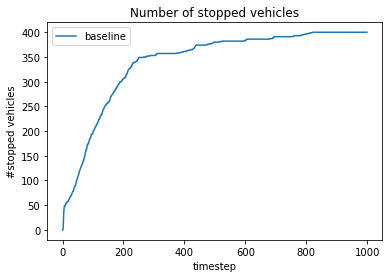

In [27]:
t,v = get_stopped_vehicles_from_output(output_file)
plot_stopped_vehicles([t], [v], ["baseline"])